In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))



df = pd.read_csv(os.path.join(os.getcwd(), "../../data/total_4am.csv"), index_col=0)


In [2]:
import pandas as pd
from performance import get_performance, draw_graph

def various_momentum(momentum_list, df):

    original_df = df.copy()  # Make a copy of the original DataFrame

    for momentum in momentum_list:
        df = original_df.copy()  # Create a fresh copy for each momentum

        df[f"{momentum}_momentum"] = 0

        # Implement RSI strategy for long positions only
        df['signal'] = 0  # Default to no position
        for i in range(200, len(df)):
            df.loc[i, f"{momentum}_momentum"] = df.loc[i, "close"] - df.loc[i-momentum, "close"]
            # Buy condition
            if df[f'{momentum}_momentum'].iloc[i] >= 0 and df[f'{momentum}_momentum'].iloc[i-1] < 0:
                df.loc[i, 'signal'] = 1
            # Sell condition
            elif df[f'{momentum}_momentum'].iloc[i] < 0 and df[f'{momentum}_momentum'].iloc[i-1] >= 0:
                df.loc[i, 'signal'] = -1
        # # Manage positions with stop loss, take profit, and sell signal
        # df['position'] = 0
        # df['entry_price'] = np.nan
        # df['exit_price'] = np.nan
        # holding_position = False

        # for i in range(1, len(df)):
        #     if df['signal'].iloc[i] == 1 and not holding_position:
        #         # Enter position
        #         df.loc[i, 'position'] = 1
        #         df.loc[i, 'entry_price'] = df.loc[i, 'close']
        #         holding_position = True
        #     elif holding_position:
        #         # Calculate percentage change since entry
        #         entry_price = df['entry_price'].iloc[i-1]
        #         current_price = df['close'].iloc[i]
        #         percent_change = (current_price - entry_price) / entry_price * 100

        #         if df['signal'].iloc[i] == -1:  # Sell signal condition
        #             # print(f"cond1 on{i}")
        #             df.loc[i, 'position'] = 0
        #             df.loc[i, 'exit_price'] = current_price
        #             holding_position = False
        #         elif percent_change <= -5:  # Stop loss condition
        #             # print(f"cond2 on{i}")
        #             df.loc[i, 'position'] = 0
        #             df.loc[i, 'exit_price'] = current_price
        #             holding_position = False
        #         # elif percent_change >= 30:  # Take profit condition
        #         #     print(f"cond3 on{i}")
        #         #     df['position'].iloc[i] = 0
        #         #     df['exit_price'].iloc[i] = current_price
        #         #     holding_position = False
        #         else:
        #             # Continue holding the position if no sell conditions are met
        #             # df['position'].iloc[i] = df['position'].iloc[i-1]
        #             df.loc[i, 'position'] = df.loc[i-1, 'position']
        #             # df['entry_price'].iloc[i] = df['entry_price'].iloc[i-1]
        #             df.loc[i, 'entry_price'] = df.loc[i-1, 'entry_price']
        #     else:
        #         # No signal and no position
        #         # df['position'].iloc[i] = df['position'].iloc[i-1]
        #         df.loc[i, 'position'] = df.loc[i-1, 'position']

        # Manage positions with stop loss, take profit, and sell signal
        df['position'] = 0
        df['highest_price'] = np.nan
        df['exit_price'] = np.nan
        holding_position = False

        for i in range(1, len(df)):
            if df['signal'].iloc[i] == 1 and not holding_position:
                # Enter position
                df.loc[i, 'position'] = 1
                df.loc[i, 'highest_price'] = df.loc[i, 'close']
                holding_position = True
            elif holding_position:
                # Calculate percentage change since entry
                # df['highest_price'].iloc[i] = max(df['highest_price'].iloc[i-1], df['close'].iloc[i])
                df.loc[i, 'highest_price'] = max(df.loc[i-1, 'highest_price'], df.loc[i-1, 'close'])
                highest_price = df['highest_price'].iloc[i]
                current_price = df['close'].iloc[i]
                percent_change = (current_price - highest_price) / highest_price * 100

                if df['signal'].iloc[i] == -1:  # Sell signal condition
                    # print(f"cond1 on{i}")
                    df.loc[i, 'position'] = 0
                    df.loc[i, 'exit_price'] = current_price
                    holding_position = False
                elif percent_change <= -5:  # Stop loss condition
                    # print(f"cond2 on{i}")
                    df.loc[i, 'position'] = 0
                    df.loc[i, 'exit_price'] = current_price
                    holding_position = False
                else:
                    # Continue holding the position if no sell conditions are met
                    df.loc[i, 'position'] = df.loc[i-1, 'position']

            else:
                # No signal and no position
                # df['position'].iloc[i] = df['position'].iloc[i-1]
                df.loc[i, 'position'] = df.loc[i-1, 'position']
                
        # Calculate the strategy returns (only when in a long position)
        df['strategy_returns'] = df['position'].shift(1) * df['close'].pct_change()

        df['strategy_returns2'] = df['strategy_returns']
        
        for i in range(1, len(df)):
            buy_price = df.loc[i-1, "close"]
            buy_price_copy = buy_price
            sell_price = df.loc[i, "close"]
            sell_price_copy = sell_price
            if df.loc[i-1, 'position'] == 1 and df.loc[i-1, 'signal'] == 1:
                # df.loc[i, 'strategy_returns2'] = (df.loc[i,'position'])/(df.loc[i-1, 'position'] * 1.002) -1
                buy_price = df.loc[i-1, "close"] * 1.002
            if df.loc[i, 'position'] == 0 and df.loc[i-1, 'position'] != 0:
                # df.loc[i, 'strategy_returns2'] = (df.loc[i,'position'] * 0.998)/(df.loc[i-1, 'position']) -1
                sell_price = df.loc[i, "close"] * 0.998
            
            if buy_price == buy_price_copy and sell_price == sell_price_copy:
                continue


            df.loc[i, "strategy_returns2"] = sell_price/buy_price - 1

        df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

        df["cumulative_returns2"] = (1 + df['strategy_returns2']).cumprod()

        # Calculate the benchmark cumulative returns (buy and hold strategy)
        df['benchmark_returns'] = (1 + df['close'].pct_change()).cumprod()

        # Save the results to a CSV file
        df.to_csv(f"../../results/momentum/simple_mmt_{(momentum)}_cut_highest.csv")

        # Get performance metrics and plot the results
        excel_path = "../../results/results.xlsx"
        get_performance(df=df, title=f"simple_mmt_{momentum}_cut_highest5%", add_to_excel=True, file_path=excel_path)
        draw_graph(df=df)

        
    df = original_df.copy()  # Create a fresh copy for each momentum


======Investment Summary======
Strategy        : simple_mmt_30_cut_highest5%
total_return    : 152.29
cagr            : 40.52
mdd             : 18.06
total_return_w_fee : 116.71
cagr_w_fee      : 32.88
mdd_w_fee       : 20.31
investing_days  : 993


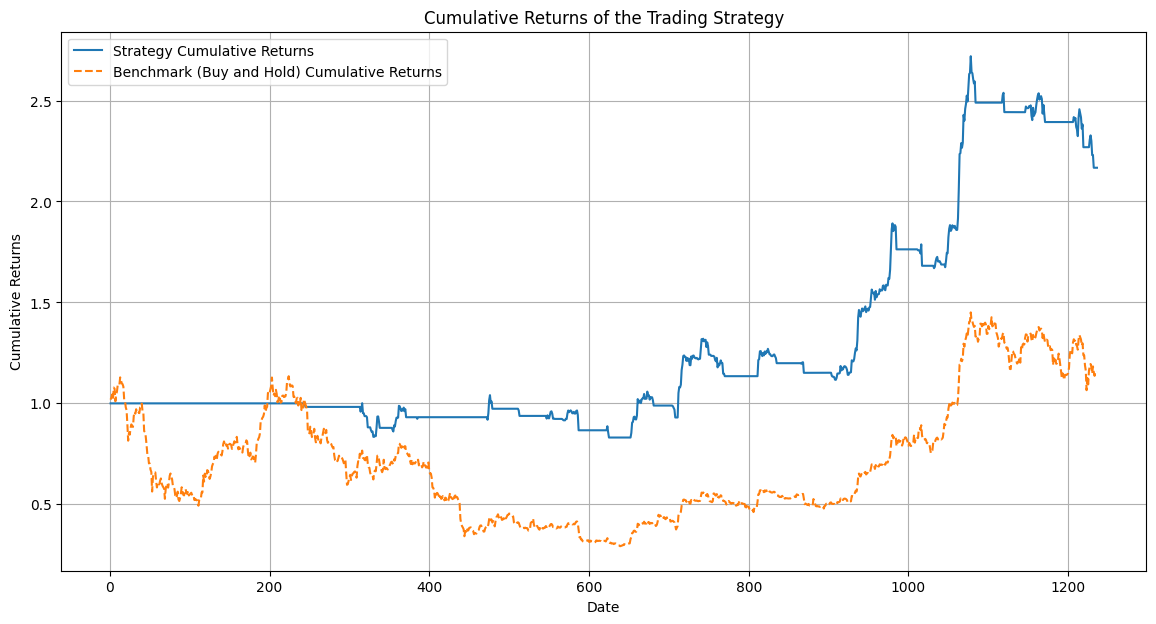

======Investment Summary======
Strategy        : simple_mmt_60_cut_highest5%
total_return    : 68.57
cagr            : 23.76
mdd             : 31.84
total_return_w_fee : 56.24
cagr_w_fee      : 19.98
mdd_w_fee       : 33.85
investing_days  : 894


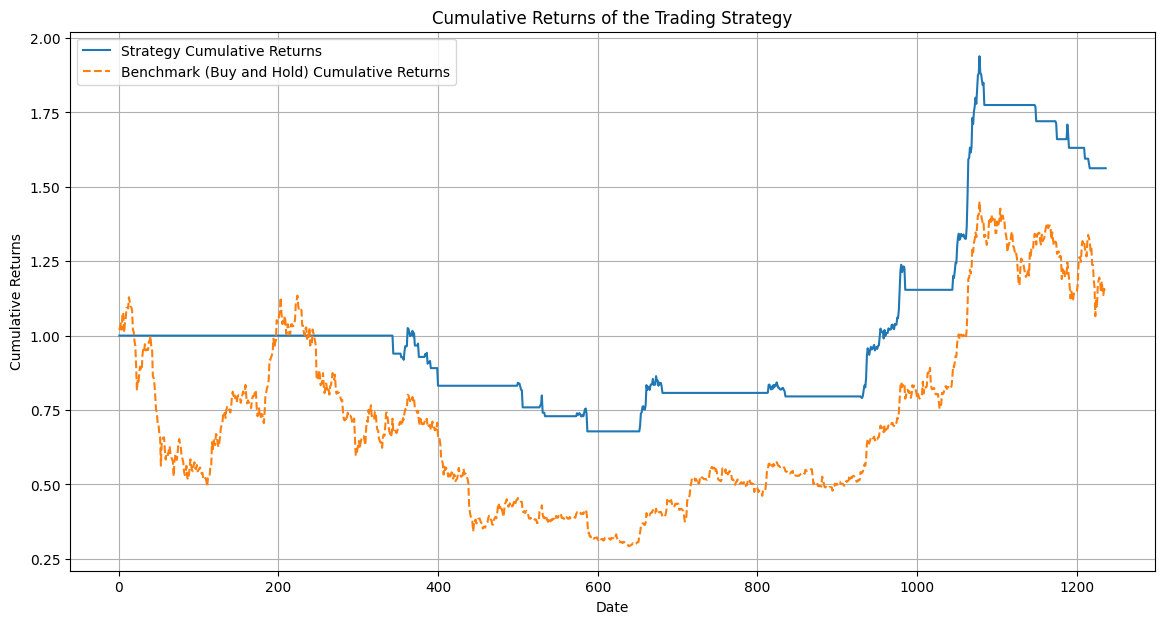

======Investment Summary======
Strategy        : simple_mmt_90_cut_highest5%
total_return    : 1.26
cagr            : 0.53
mdd             : 29.43
total_return_w_fee : -7.27
cagr_w_fee      : -3.12
mdd_w_fee       : 34.73
investing_days  : 869


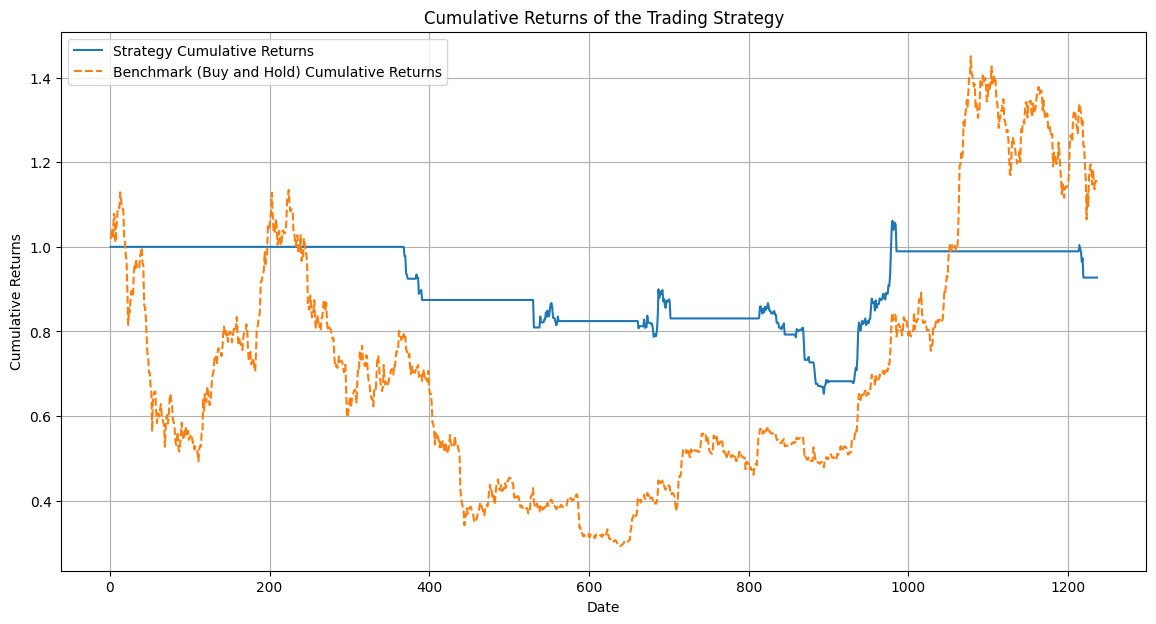

======Investment Summary======
Strategy        : simple_mmt_120_cut_highest5%
total_return    : 25.24
cagr            : 12.94
mdd             : 18.44
total_return_w_fee : 20.81
cagr_w_fee      : 10.76
mdd_w_fee       : 19.74
investing_days  : 675


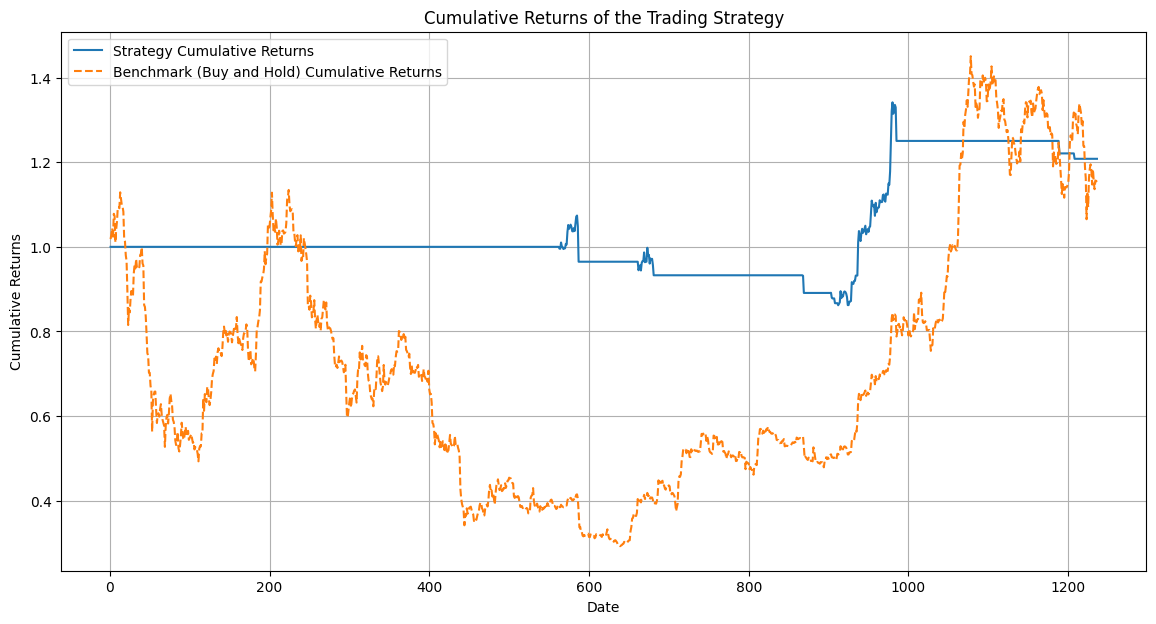

======Investment Summary======
Strategy        : simple_mmt_150_cut_highest5%
total_return    : 107.1
cagr            : 33.45
mdd             : 9.26
total_return_w_fee : 101.38
cagr_w_fee      : 31.97
mdd_w_fee       : 10.31
investing_days  : 921


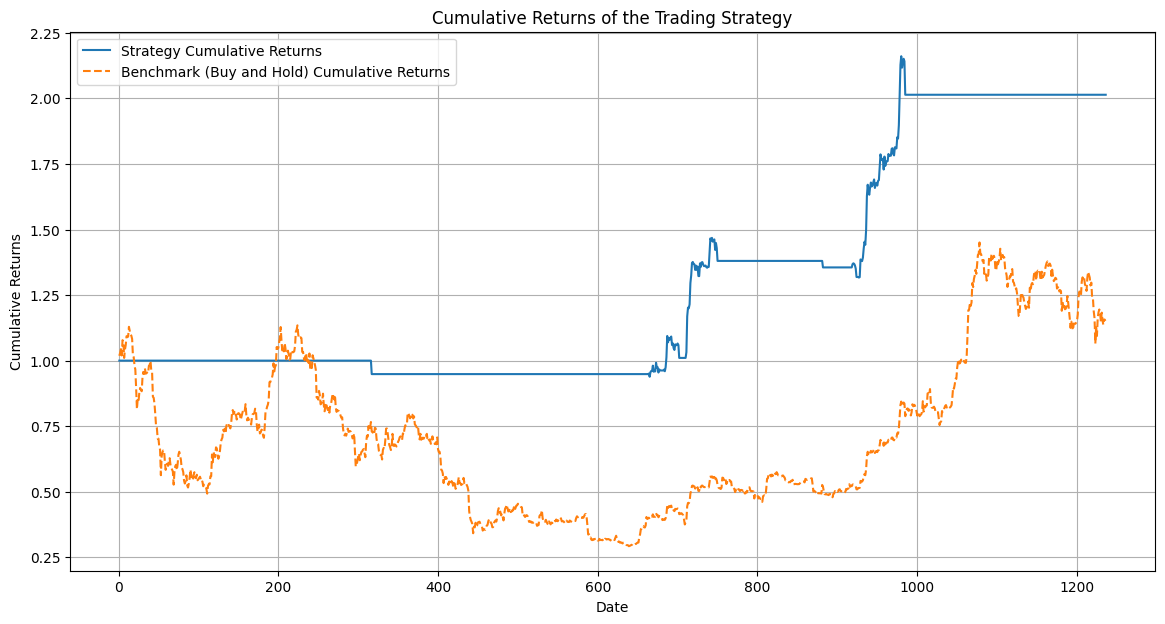

======Investment Summary======
Strategy        : simple_mmt_180_cut_highest5%
total_return    : 67.55
cagr            : 22.29
mdd             : 9.81
total_return_w_fee : 60.98
cagr_w_fee      : 20.4
mdd_w_fee       : 11.25
investing_days  : 936


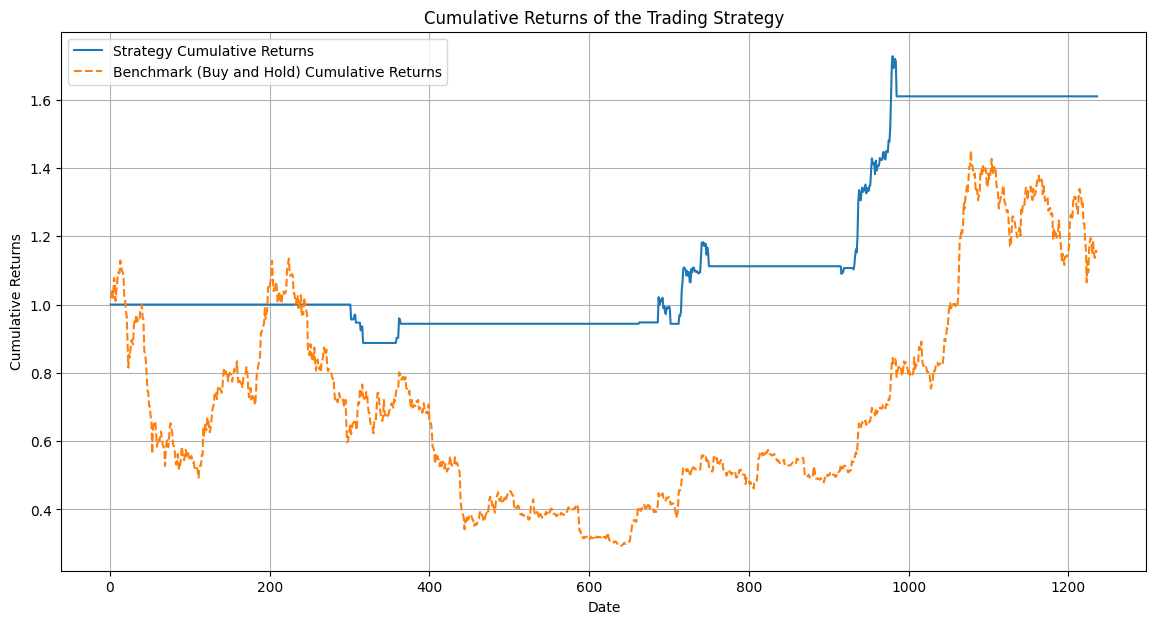

In [3]:
# momentum_list = [30, 60, 90, 120, 150, 180, 360]
momentum_list = [30, 60, 90, 120, 150, 180]
various_momentum(momentum_list=momentum_list, df=df,)